In [1]:
# Install required packages
!pip install torch torchvision torchaudio
!pip install matplotlib seaborn pandas numpy
!pip install kaggle

# Import libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import zipfile
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 69.6 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 61.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 33.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 23.4 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 12.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 74.1 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5

In [3]:
# For Kaggle Notebook - Dataset is already available in /kaggle/input
import os

# Set the dataset path
dataset_path = '/kaggle/input/the-wildfire-dataset/the_wildfire_dataset_2n_version'
print(f"Dataset path: {dataset_path}")

# Explore the structure
print("Dataset structure:")
for split in ['test', 'train', 'val']:
    split_path = os.path.join(dataset_path, split)
    if os.path.exists(split_path):
        print(f"\n📁 {split}/")
        for class_name in ['fire', 'nofire']:
            class_path = os.path.join(split_path, class_name)
            if os.path.exists(class_path):
                num_images = len([f for f in os.listdir(class_path) 
                                if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
                print(f"  📁 {class_name}/: {num_images} images")

# Count total images
total_images = 0
for split in ['test', 'train', 'val']:
    for class_name in ['fire', 'nofire']:
        class_path = os.path.join(dataset_path, split, class_name)
        if os.path.exists(class_path):
            images = [f for f in os.listdir(class_path) 
                     if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
            total_images += len(images)
            print(f"{split}/{class_name}: {len(images)} images")

print(f"\nTotal images: {total_images}")

Dataset path: /kaggle/input/the-wildfire-dataset/the_wildfire_dataset_2n_version
Dataset structure:

📁 test/
  📁 fire/: 159 images
  📁 nofire/: 251 images

📁 train/
  📁 fire/: 730 images
  📁 nofire/: 1157 images

📁 val/
  📁 fire/: 156 images
  📁 nofire/: 246 images
test/fire: 159 images
test/nofire: 251 images
train/fire: 730 images
train/nofire: 1157 images
val/fire: 156 images
val/nofire: 246 images

Total images: 2699


In [5]:
class WildfireBinaryDataset(Dataset):
    def __init__(self, data_dir, split='train', transform=None):
        """
        Dataset for binary classification (fire vs nofire)
        
        Args:
            data_dir: Root directory of the dataset
            split: One of 'train', 'test', 'val'
            transform: Image transformations
        """
        self.data_dir = os.path.join(data_dir, split)
        self.transform = transform
        self.classes = ['nofire', 'fire']  # Important: nofire=0, fire=1
        self.class_to_idx = {'nofire': 0, 'fire': 1}
        
        # Collect all image paths and labels
        self.image_paths = []
        self.labels = []
        
        for class_name in self.classes:
            class_dir = os.path.join(self.data_dir, class_name)
            if os.path.exists(class_dir):
                for img_name in os.listdir(class_dir):
                    if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                        self.image_paths.append(os.path.join(class_dir, img_name))
                        self.labels.append(self.class_to_idx[class_name])
        
        print(f"Found {len(self.image_paths)} images in {split} split")
        print(f"Class distribution:")
        for class_name in self.classes:
            count = sum(1 for label in self.labels if label == self.class_to_idx[class_name])
            print(f"  {class_name}: {count} images ({count/len(self.labels)*100:.1f}%)")
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

In [6]:
# Define data transformations for binary classification
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

# Create datasets for all splits
train_dataset = WildfireBinaryDataset(dataset_path, split='train', transform=data_transforms['train'])
val_dataset = WildfireBinaryDataset(dataset_path, split='val', transform=data_transforms['val'])
test_dataset = WildfireBinaryDataset(dataset_path, split='test', transform=data_transforms['test'])

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

print(f"\nData loaders created:")
print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Testing samples: {len(test_dataset)}")
print(f"Number of classes: {len(train_dataset.classes)}")

Found 1887 images in train split
Class distribution:
  nofire: 1157 images (61.3%)
  fire: 730 images (38.7%)
Found 402 images in val split
Class distribution:
  nofire: 246 images (61.2%)
  fire: 156 images (38.8%)
Found 410 images in test split
Class distribution:
  nofire: 251 images (61.2%)
  fire: 159 images (38.8%)

Data loaders created:
Training samples: 1887
Validation samples: 402
Testing samples: 410
Number of classes: 2


In [7]:
def create_binary_model():
    """Create a MobileNetV2 model for binary classification"""
    # Load pre-trained MobileNetV2
    model = models.mobilenet_v2(weights='IMAGENET1K_V1')
    
    # Freeze early layers for transfer learning
    for param in model.parameters():
        param.requires_grad = False
    
    # Replace the classifier for binary classification
    model.classifier = nn.Sequential(
        nn.Dropout(0.2),
        nn.Linear(model.last_channel, 1),  # Single output for binary classification
        nn.Sigmoid()  # Sigmoid activation for binary classification
    )
    
    # Unfreeze the classifier parameters
    for param in model.classifier.parameters():
        param.requires_grad = True
        
    return model

# Create model
model = create_binary_model()
model = model.to(device)

print("Binary classification model created successfully!")
print(f"Model architecture:\n{model}")

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 119MB/s] 


Binary classification model created successfully!
Model architecture:
MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=

In [8]:
def train_binary_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    train_losses = []
    val_accuracies = []
    best_val_acc = 0.0
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device).float().unsqueeze(1)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            predicted = (outputs > 0.5).float()
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
        
        train_accuracy = 100 * correct_train / total_train
        train_losses.append(running_loss / len(train_loader))
        
        # Validation phase
        model.eval()
        correct_val = 0
        total_val = 0
        
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device).float().unsqueeze(1)
                outputs = model(images)
                predicted = (outputs > 0.5).float()
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()
        
        val_accuracy = 100 * correct_val / total_val
        val_accuracies.append(val_accuracy)
        
        # Save best model
        if val_accuracy > best_val_acc:
            best_val_acc = val_accuracy
            torch.save(model.state_dict(), 'best_wildfire_model.pth')
        
        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Loss: {running_loss/len(train_loader):.4f}, '
              f'Train Acc: {train_accuracy:.2f}%, '
              f'Val Acc: {val_accuracy:.2f}%')
    
    return train_losses, val_accuracies

# Use Binary Cross Entropy Loss for binary classification
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

print("Starting training for binary classification...")
train_losses, val_accuracies = train_binary_model(
    model, train_loader, val_loader, criterion, optimizer, num_epochs=4
)

Starting training for binary classification...
Epoch [1/4], Loss: 0.5540, Train Acc: 71.54%, Val Acc: 77.36%
Epoch [2/4], Loss: 0.4731, Train Acc: 76.74%, Val Acc: 81.09%
Epoch [3/4], Loss: 0.4322, Train Acc: 80.55%, Val Acc: 82.59%
Epoch [4/4], Loss: 0.4085, Train Acc: 80.66%, Val Acc: 82.59%


Classification Report:
              precision    recall  f1-score   support

      nofire       0.90      0.93      0.91       251
        fire       0.89      0.83      0.86       159

    accuracy                           0.89       410
   macro avg       0.89      0.88      0.89       410
weighted avg       0.89      0.89      0.89       410



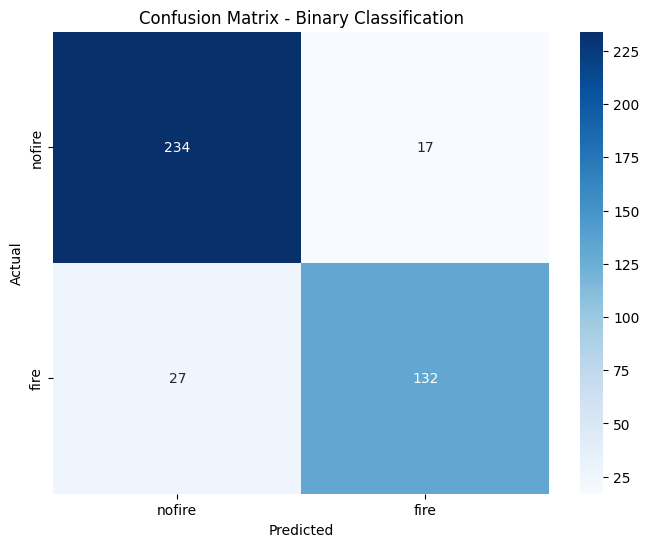

In [10]:
def evaluate_binary_model(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []
    all_probabilities = []
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device).float().unsqueeze(1)
            outputs = model(images)
            probabilities = outputs.cpu().numpy()
            predicted = (outputs > 0.5).float().cpu().numpy()
            
            all_preds.extend(predicted.flatten())
            all_labels.extend(labels.cpu().numpy().flatten())
            all_probabilities.extend(probabilities.flatten())
    
    return all_preds, all_labels, all_probabilities

# Evaluate on test set
all_preds, all_labels, all_probabilities = evaluate_binary_model(model, test_loader)

# Convert to integers for classification report
all_preds_int = [int(p) for p in all_preds]
all_labels_int = [int(l) for l in all_labels]

# Classification report
class_names = ['nofire', 'fire']
print("Classification Report:")
print(classification_report(all_labels_int, all_preds_int, target_names=class_names))

# Confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(all_labels_int, all_preds_int)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix - Binary Classification')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()